<a href="https://colab.research.google.com/github/jeetrico/SMS-Spam-Detection-System-Using-NLP/blob/main/SMS_SPAM_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


First 5 rows of the cleaned dataset:
   label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Class Distribution:
label
0    4516
1     653
Name: count, dtype: int64


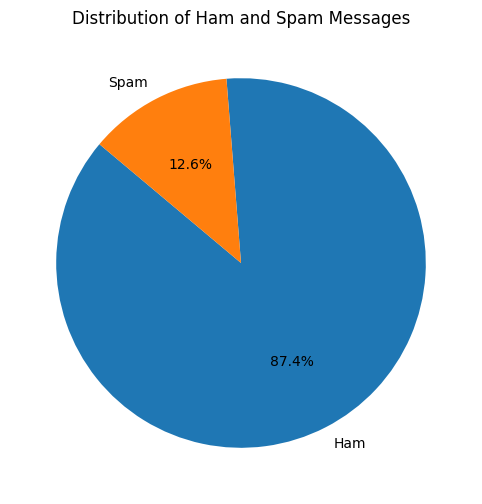


Sample of data with text statistics:
    label                                               text  count_characters  \
0      0  Go until jurong point, crazy.. Available only ...               111   
1      0                      Ok lar... Joking wif u oni...                29   
2      1  Free entry in 2 a wkly comp to win FA Cup fina...               155   
3      0  U dun say so early hor... U c already then say...                49   
4      0  Nah I don't think he goes to usf, he lives aro...                61   

   count_words  count_sentences  
0           24                2  
1            8                2  
2           37                2  
3           13                1  
4           15                1  


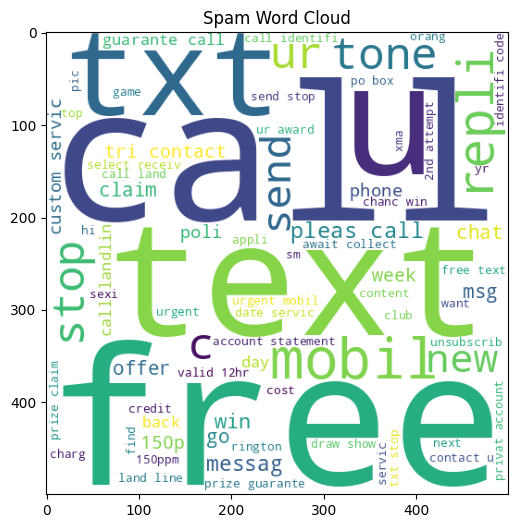

MultinomialNB Performance:
Accuracy: 0.965183752417795
Precision: 0.8231292517006803
Confusion Matrix:
 [[877  26]
 [ 10 121]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       903
           1       0.82      0.92      0.87       131

    accuracy                           0.97      1034
   macro avg       0.91      0.95      0.93      1034
weighted avg       0.97      0.97      0.97      1034


Model and vectorizer saved successfully!


In [ ]:
#---------------------------------------------------------------------------------------
# SMS Spam Detection - Project by Jeet Banerjee
#---------------------------------------------------------------------------------------

# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Model Persistence
from joblib import dump, load
import json

# Word Cloud
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

#---------------------------------------------------------------------------------------
# Configuration (Project-Specific Settings)
#---------------------------------------------------------------------------------------
DATASET_PATH = 'sms-spam.csv'  # *** REPLACE WITH YOUR ACTUAL DATASET PATH IF DIFFERENT ***
MODEL_FILENAME = 'spam_model.joblib'
VECTORIZER_FILENAME = 'tfidf_vectorizer.joblib'
RANDOM_STATE = 42  # For reproducibility
TEST_SIZE = 0.2

#---------------------------------------------------------------------------------------
# Data Loading and Cleaning
#---------------------------------------------------------------------------------------
def load_and_clean_data(dataset_path):
    """
    Loads the data, handles encoding issues, removes extra columns, renames columns,
    drops missing values, and removes duplicates.
    """
    try:
        data = pd.read_csv(dataset_path, encoding='utf-8')
    except UnicodeDecodeError:
        data = pd.read_csv(dataset_path, encoding='latin-1')

    data = data.iloc[:, :2]
    data.columns = ['label', 'text']
    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)
    return data

data = load_and_clean_data(DATASET_PATH)
print("First 5 rows of the cleaned dataset:\n", data.head())

#---------------------------------------------------------------------------------------
# Label Encoding
#---------------------------------------------------------------------------------------
def encode_labels(data, label_column='label'):
    """Encodes categorical labels into numerical values."""
    encoder = LabelEncoder()
    data[label_column] = encoder.fit_transform(data[label_column])
    return data

data = encode_labels(data)

#---------------------------------------------------------------------------------------
# Exploratory Data Analysis (EDA)
#---------------------------------------------------------------------------------------
def perform_eda(data, label_column='label'):
    """Performs exploratory data analysis and visualizes class distribution."""
    print("\nClass Distribution:")
    print(data[label_column].value_counts())

    plt.figure(figsize=(8, 6))
    plt.pie(data[label_column].value_counts(), labels=['Ham', 'Spam'], autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Ham and Spam Messages')
    plt.show()

perform_eda(data)

#---------------------------------------------------------------------------------------
# Feature Engineering (Text Statistics)
#---------------------------------------------------------------------------------------
def calculate_text_stats(df, text_column='text'):
    """Calculates text statistics (character, word, sentence counts)."""
    df.loc[:, 'count_characters'] = df[text_column].apply(len)
    df.loc[:, 'count_words'] = df[text_column].apply(lambda x: len(nltk.word_tokenize(x)))
    df.loc[:, 'count_sentences'] = df[text_column].apply(lambda x: len(nltk.sent_tokenize(x)))
    return df

data = calculate_text_stats(data)
print("\nSample of data with text statistics:\n", data.head())

#---------------------------------------------------------------------------------------
# Text Transformation (Preprocessing)
#---------------------------------------------------------------------------------------
def transform_text(text):
    """Converts text to lowercase, tokenizes, removes special characters, stopwords, and punctuation, and applies stemming."""
    if not isinstance(text, str):
        return ""  # Handle non-string input
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    alphanumeric_tokens = [token for token in tokens if token.isalnum()]
    filtered_tokens = [token for token in alphanumeric_tokens if token not in stopwords.words('english') and token not in string.punctuation]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return " ".join(stemmed_tokens)

data['processed_text'] = data['text'].apply(transform_text)

#---------------------------------------------------------------------------------------
# Data Visualization (Word Cloud)
#---------------------------------------------------------------------------------------
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
spam_wc = wc.generate(data[data['label'] == 1]['processed_text'].str.cat(sep=" "))

plt.figure(figsize=(12, 6))
plt.imshow(spam_wc)
plt.title("Spam Word Cloud")
plt.show()

#---------------------------------------------------------------------------------------
# Model Building and Evaluation
#---------------------------------------------------------------------------------------
X = data['processed_text']
y = data['label']

# TF-IDF Vectorization
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# MultinomialNB classifier
mnb = MultinomialNB()

# Train the model on the resampled data
mnb.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = mnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("MultinomialNB Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#---------------------------------------------------------------------------------------
# Model Persistence (Using joblib - safer alternative)
#---------------------------------------------------------------------------------------
dump(mnb, MODEL_FILENAME)
dump(tfidf, VECTORIZER_FILENAME)

print("\nModel and vectorizer saved successfully!")

In [ ]:
from joblib import load
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
#Importing Library to use
ps = PorterStemmer()
#Loading dependecies, should already be done here

def transform_text(text):
    """Converts text to lowercase, tokenizes, removes special characters, stopwords, and punctuation, and applies stemming."""
    if not isinstance(text, str):
        return ""  # Handle non-string input
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    alphanumeric_tokens = [token for token in tokens if token.isalnum()]
    filtered_tokens = [token for token in alphanumeric_tokens if token not in stopwords.words('english') and token not in string.punctuation]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return " ".join(stemmed_tokens)

try:
    mnb = load('spam_model.joblib') #load the model
    tfidf = load('tfidf_vectorizer.joblib') #load the encoder
    print("Model and vectorizer loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading model or vectorizer: {e}. Make sure the files are in the same directory as the script.")
    exit() #stop program

while True:
    sms_input = input("Enter an SMS message (or type 'exit' to quit): ")
    if sms_input.lower() == 'exit':
        break
    processed_text = transform_text(sms_input)
    vectorized_text = tfidf.transform([processed_text])
    prediction = mnb.predict(vectorized_text)[0]

    if prediction == 1:
        print("Prediction: SPAM")
    else:
        print("Prediction: HAM")

Model and vectorizer loaded successfully!
Enter an SMS message (or type 'exit' to quit): HI! THIS IS JEET BANERJEE.
Prediction: HAM
Enter an SMS message (or type 'exit' to quit): HI CAN YOU SEND ME YOUR CREDIT CARD DETAILS??
Prediction: SPAM
Enter an SMS message (or type 'exit' to quit): exit


In [20]:
from google.colab import files

files.download('sms-spam.csv')
files.download('spam_model.joblib')
files.download('tfidf_vectorizer.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>